In [1]:
from dataclasses import dataclass

from pathlib import Path

import numpy as np

from sklearn.metrics import f1_score, jaccard_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU, AUC
from tensorflow.keras.callbacks import (
    Callback,
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt


2022-02-17 09:25:43.869023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 09:25:43.869045: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
img_size = (256, 256)
num_classes = 8
batch_size = 32

model_name = "unet_xception_256"
model_path = Path("./../results/", model_name)


In [3]:
@dataclass(frozen=True)
class CityscapesCategory:
    """Cityscapes categories.

    Attributes:
        id: The category id
        name: The category name
        color: The category color
    """

    id: int
    name: str
    color_rgb: tuple[int, int, int]
    label_ids: list[int]


# Cityscape categories
CITYSCAPES_CATEGORIES = [
    CityscapesCategory(
        0,
        "void",
        (0, 0, 0),  # black
        list(range(0, 7)),
    ),
    CityscapesCategory(
        1,
        "flat",
        (128, 64, 128),  # purple
        list(range(7, 11)),
    ),
    CityscapesCategory(
        2,
        "construction",
        (70, 70, 70),  # dark gray
        list(range(11, 17)),
    ),
    CityscapesCategory(
        3,
        "object",
        (153, 153, 153),  # light gray
        list(range(17, 21)),
    ),
    CityscapesCategory(
        4,
        "nature",
        (107, 142, 35),  # olive
        list(range(21, 23)),
    ),
    CityscapesCategory(
        5,
        "sky",
        (70, 130, 180),  # blue
        list(range(23, 24)),
    ),
    CityscapesCategory(
        6,
        "human",
        (220, 20, 60),  # crimson
        list(range(24, 26)),
    ),
    CityscapesCategory(
        7,
        "vehicle",
        (0, 0, 142),  # navy
        [-1] + list(range(26, 34)),
    ),
]


def cityscapes_label_ids_to_category_ids(img: np.array) -> np.array:
    """Convert cityscapes label ids to category ids.

    Args:
        img: Cityscapes label ids image

    Returns:
        Category ids image
    """
    if not len(img.shape) == 2:
        raise ValueError("Image must be of shape (H, W).")

    category_ids = np.zeros(img.shape, dtype=np.uint8)

    for category in CITYSCAPES_CATEGORIES:
        for label_id in category.label_ids:
            category_ids[img == label_id] = category.id

    return category_ids


def cityscapes_category_ids_to_category_colors(img: np.array) -> np.array:
    """Convert cityscapes category ids to colors.

    Args:
        img: Cityscapes category ids image

    Returns:
        Category colors image
    """
    if not len(img.shape) == 2:
        raise ValueError("Image must be of shape (H, W).")

    category_colors = np.zeros(img.shape + (3,), dtype=np.uint8)

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            category_colors[row, col] = CITYSCAPES_CATEGORIES[
                img[row, col]
            ].color_rgb

    return category_colors


In [4]:
# Train dataset
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")


train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_labelIds.png")
)
train_label_colors_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(leftImg8bit_path, "test").glob("**/*.png")
)
test_label_ids_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_color.png")
)


Original image


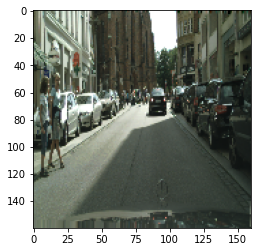

Original label IDs


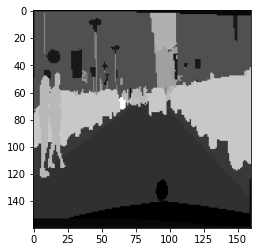

Category IDs


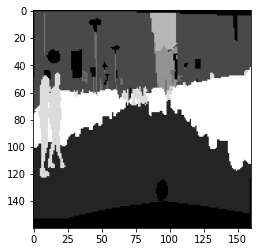

Category colors


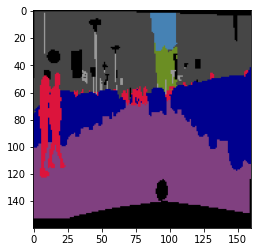

Original label colors


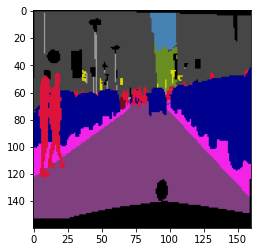

In [5]:
rand_idx = np.random.randint(0, len(train_input_img_paths))


print("Original image")
input_img = load_img(train_input_img_paths[rand_idx], target_size=img_size)
plt.imshow(input_img)
plt.show()

print("Original label IDs")
label_ids = load_img(
    train_label_ids_img_paths[rand_idx],
    target_size=img_size,
    color_mode="grayscale",
)
plt.imshow(label_ids, cmap="gray")
plt.show()

print("Category IDs")
category_ids = cityscapes_label_ids_to_category_ids(np.array(label_ids))
plt.imshow(category_ids, cmap="gray")
plt.show()

print("Category colors")
category_colors = cityscapes_category_ids_to_category_colors(category_ids)
plt.imshow(category_colors)
plt.show()

print("Original label colors")
input_img = load_img(
    train_label_colors_img_paths[rand_idx], target_size=img_size
)
plt.imshow(input_img)
plt.show()


In [6]:
class CityscapesGenerator(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(
        self, batch_size, img_size, input_img_paths, label_ids_img_paths
    ):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.label_ids_img_paths = label_ids_img_paths

    def __len__(self):
        return len(self.label_ids_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.uint8)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        batch_label_ids_img_paths = self.label_ids_img_paths[
            i : i + self.batch_size
        ]
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.uint8)
        for j, path in enumerate(batch_label_ids_img_paths):
            y[j] = np.expand_dims(
                cityscapes_label_ids_to_category_ids(
                    np.array(
                        load_img(
                            path,
                            target_size=self.img_size,
                            color_mode="grayscale",
                        )
                    )
                ),
                2,
            )

        return x, y


class CityscapesViewerCallback(Callback):
    def on_epoch_end(self, epoch=None, logs=None):
        rand_idx = np.random.randint(0, len(test_input_img_paths))

        test_img = np.array(
            load_img(test_input_img_paths[rand_idx], target_size=img_size)
        )
        plt.imshow(test_img)
        plt.show()

        pred = cityscapes_category_ids_to_category_colors(
            np.squeeze(
                np.argmax(
                    self.model.predict(np.expand_dims(test_img, 0)), axis=-1
                )
            )
        )
        plt.imshow(pred)
        plt.show()


class UpdatedMeanIoU(MeanIoU):
    """Custom metric to report the mean IoU over the entire batch.

    See : https://github.com/tensorflow/tensorflow/issues/32875#issuecomment-707316950
    """

    def __init__(
        self, y_true=None, y_pred=None, num_classes=None, name=None, dtype=None
    ):
        super(UpdatedMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


def jaccard_loss(y_true, y_pred, smooth=100.0):
    """
    See : https://towardsdatascience.com/image-segmentation-choosing-the-correct-metric-aa21fd5751af
    """

    y_true = tf.squeeze(tf.one_hot(y_true, num_classes))

    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)

    return (1 - jac) * smooth


In [7]:
def unet_xception_model(img_size, num_classes, model_name="unet_xception"):
    """Creates a U-Net model with Xception as the encoder.

    See : https://keras.io/examples/vision/oxford_pets_image_segmentation/

    Args:
        img_size: tuple of (height, width)
        num_classes: number of classes to predict

    Returns:
        keras.models.Model
    """
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(
        num_classes, 3, activation="softmax", padding="same"
    )(x)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    return model


# Free up RAM in case the model definition cells were run multiple times
clear_session()

# Build model
if Path(model_path).exists():
    model = load_model(
        Path(model_path, "model"),
        custom_objects={"UpdatedMeanIoU": UpdatedMeanIoU},
    )
else:
    model = unet_xception_model(img_size, num_classes)

model.summary()


2022-02-17 09:25:47.286815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-17 09:25:47.286852: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 09:25:47.286875: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gros-bernard): /proc/driver/nvidia/version does not exist
2022-02-17 09:25:47.287165: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "unet_xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                      

Loading model from ../results/unet_xception/checkpoint.h5
Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.2624 - updated_mean_io_u: 0.5935
Epoch 1: val_loss improved from inf to 0.34136, saving model to ../results/unet_xception/checkpoint.h5


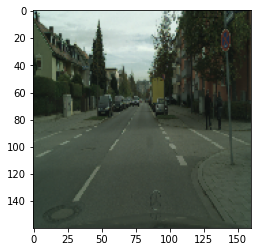

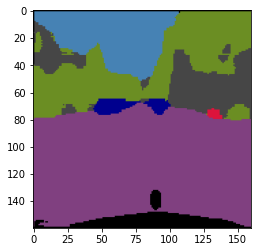

92/92 [==============================] - 476s 5s/step - loss: 0.2624 - updated_mean_io_u: 0.5935 - val_loss: 0.3414 - val_updated_mean_io_u: 0.5427 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.2351 - updated_mean_io_u: 0.6165
Epoch 2: val_loss did not improve from 0.34136


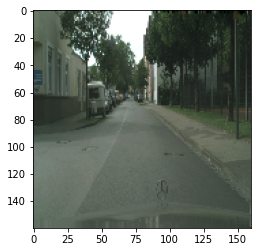

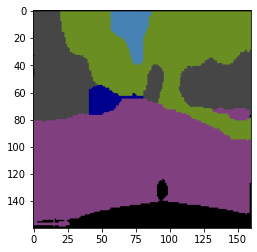

92/92 [==============================] - 486s 5s/step - loss: 0.2351 - updated_mean_io_u: 0.6165 - val_loss: 0.3539 - val_updated_mean_io_u: 0.5274 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.2267 - updated_mean_io_u: 0.6263
Epoch 3: val_loss improved from 0.34136 to 0.32827, saving model to ../results/unet_xception/checkpoint.h5


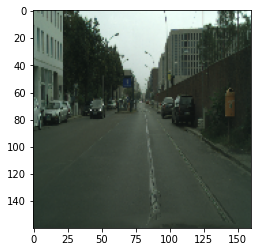

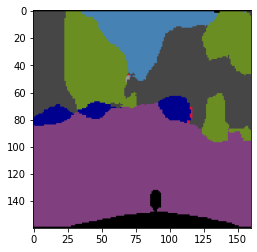

92/92 [==============================] - 465s 5s/step - loss: 0.2267 - updated_mean_io_u: 0.6263 - val_loss: 0.3283 - val_updated_mean_io_u: 0.5493 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - ETA: 0s - loss: 0.2172 - updated_mean_io_u: 0.6371
Epoch 4: val_loss improved from 0.32827 to 0.32195, saving model to ../results/unet_xception/checkpoint.h5


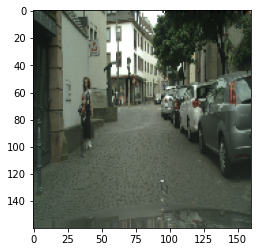

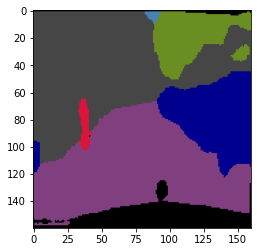

92/92 [==============================] - 462s 5s/step - loss: 0.2172 - updated_mean_io_u: 0.6371 - val_loss: 0.3219 - val_updated_mean_io_u: 0.5589 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 0.2115 - updated_mean_io_u: 0.6440
Epoch 5: val_loss did not improve from 0.32195

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


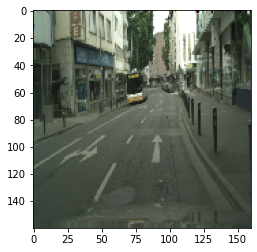

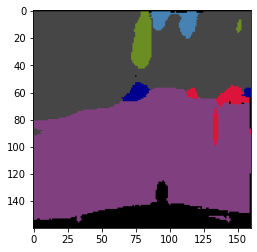

92/92 [==============================] - 456s 5s/step - loss: 0.2115 - updated_mean_io_u: 0.6440 - val_loss: 0.3522 - val_updated_mean_io_u: 0.5357 - lr: 0.0010
Epoch 6/100
92/92 [==============================] - ETA: 0s - loss: 0.1959 - updated_mean_io_u: 0.6596
Epoch 6: val_loss improved from 0.32195 to 0.31255, saving model to ../results/unet_xception/checkpoint.h5


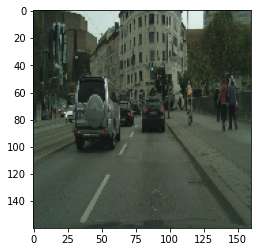

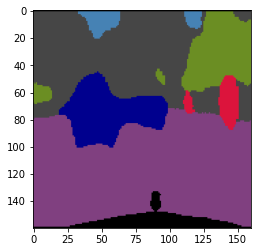

92/92 [==============================] - 451s 5s/step - loss: 0.1959 - updated_mean_io_u: 0.6596 - val_loss: 0.3125 - val_updated_mean_io_u: 0.5627 - lr: 5.0000e-04
Epoch 7/100
92/92 [==============================] - ETA: 0s - loss: 0.1872 - updated_mean_io_u: 0.6697
Epoch 7: val_loss did not improve from 0.31255


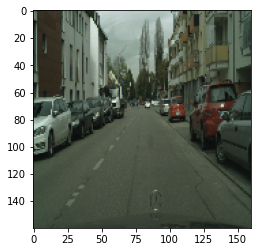

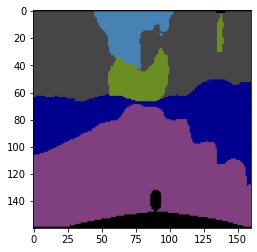

92/92 [==============================] - 470s 5s/step - loss: 0.1872 - updated_mean_io_u: 0.6697 - val_loss: 0.3137 - val_updated_mean_io_u: 0.5603 - lr: 5.0000e-04
Epoch 8/100
92/92 [==============================] - ETA: 0s - loss: 0.1801 - updated_mean_io_u: 0.6772
Epoch 8: val_loss improved from 0.31255 to 0.31079, saving model to ../results/unet_xception/checkpoint.h5

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


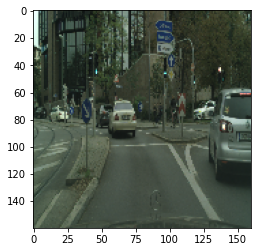

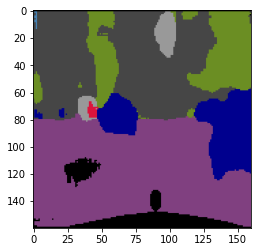

92/92 [==============================] - 483s 5s/step - loss: 0.1801 - updated_mean_io_u: 0.6772 - val_loss: 0.3108 - val_updated_mean_io_u: 0.5666 - lr: 5.0000e-04
Epoch 9/100
92/92 [==============================] - ETA: 0s - loss: 0.1708 - updated_mean_io_u: 0.6875
Epoch 9: val_loss improved from 0.31079 to 0.30730, saving model to ../results/unet_xception/checkpoint.h5


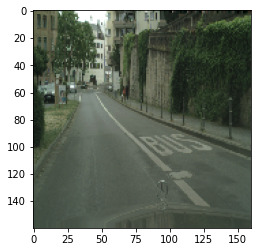

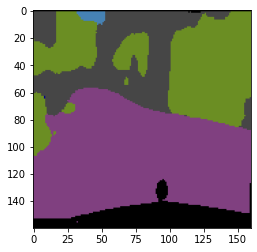

92/92 [==============================] - 484s 5s/step - loss: 0.1708 - updated_mean_io_u: 0.6875 - val_loss: 0.3073 - val_updated_mean_io_u: 0.5687 - lr: 2.5000e-04
Epoch 10/100
92/92 [==============================] - ETA: 0s - loss: 0.1648 - updated_mean_io_u: 0.6943
Epoch 10: val_loss did not improve from 0.30730

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


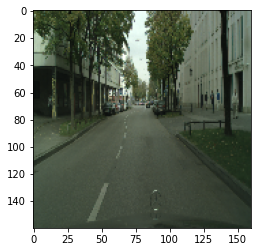

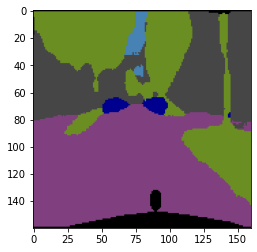

92/92 [==============================] - 474s 5s/step - loss: 0.1648 - updated_mean_io_u: 0.6943 - val_loss: 0.3102 - val_updated_mean_io_u: 0.5668 - lr: 2.5000e-04
Epoch 11/100
92/92 [==============================] - ETA: 0s - loss: 0.1596 - updated_mean_io_u: 0.7002
Epoch 11: val_loss did not improve from 0.30730


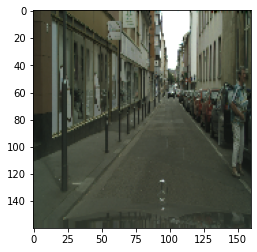

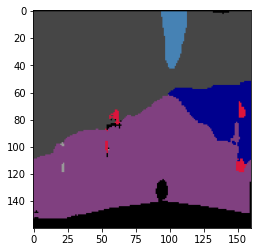

92/92 [==============================] - 481s 5s/step - loss: 0.1596 - updated_mean_io_u: 0.7002 - val_loss: 0.3098 - val_updated_mean_io_u: 0.5660 - lr: 1.2500e-04
Epoch 12/100
92/92 [==============================] - ETA: 0s - loss: 0.1568 - updated_mean_io_u: 0.7036
Epoch 12: val_loss did not improve from 0.30730

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


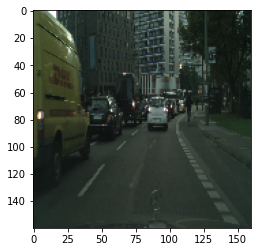

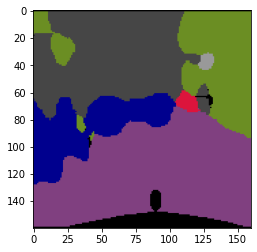

92/92 [==============================] - 479s 5s/step - loss: 0.1568 - updated_mean_io_u: 0.7036 - val_loss: 0.3100 - val_updated_mean_io_u: 0.5666 - lr: 1.2500e-04
Epoch 13/100
92/92 [==============================] - ETA: 0s - loss: 0.1540 - updated_mean_io_u: 0.7070
Epoch 13: val_loss did not improve from 0.30730


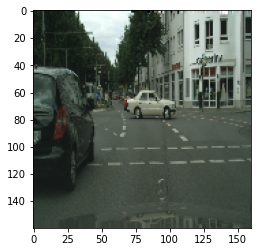

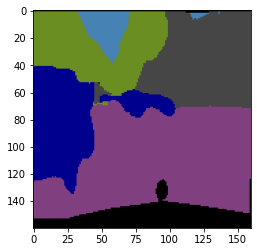

92/92 [==============================] - 475s 5s/step - loss: 0.1540 - updated_mean_io_u: 0.7070 - val_loss: 0.3083 - val_updated_mean_io_u: 0.5674 - lr: 6.2500e-05
Epoch 14/100
92/92 [==============================] - ETA: 0s - loss: 0.1525 - updated_mean_io_u: 0.7088
Epoch 14: val_loss did not improve from 0.30730

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 9.


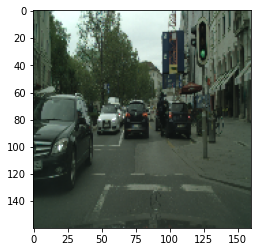

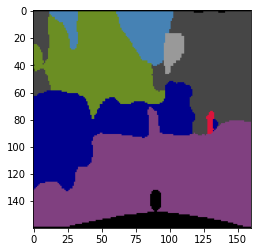

92/92 [==============================] - 484s 5s/step - loss: 0.1525 - updated_mean_io_u: 0.7088 - val_loss: 0.3092 - val_updated_mean_io_u: 0.5666 - lr: 6.2500e-05
Epoch 14: early stopping


2022-02-17 11:17:08.762776: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../results/unet_xception/model/assets


In [8]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer="adam",
    loss=jaccard_loss, # "sparse_categorical_crossentropy",
    metrics=[
        UpdatedMeanIoU(num_classes=num_classes),
    ],
)

model_checkpoint_path = Path(model_path, "checkpoint.h5")
if model_checkpoint_path.exists():
    print("Loading model from {}".format(model_checkpoint_path))
    model.load_weights(str(model_checkpoint_path))

# Train the model, doing validation at the end of each epoch.
model.fit(
    CityscapesGenerator(
        batch_size, img_size, train_input_img_paths, train_label_ids_img_paths
    ),
    validation_data=CityscapesGenerator(
        batch_size, img_size, val_input_img_paths, val_label_ids_img_paths
    ),
    epochs=100,
    callbacks=[
        ModelCheckpoint(
            model_checkpoint_path,
            save_best_only=True,
            verbose=1,
        ),
        ReduceLROnPlateau(
            patience=1,
            factor=0.5,
            min_delta=1e-2,
            min_lr=1e-7,
            verbose=1,
        ),
        EarlyStopping(
            patience=5,
            restore_best_weights=True,
            min_delta=1e-5,
            verbose=1,
        ),
        TensorBoard(log_dir=Path(model_path, "logs")),
        CityscapesViewerCallback(),
    ],
    workers=4,
    use_multiprocessing=True,
)

model.save(Path(model_path, "model"))

# Initial training time (1 worker on CPU) : ~90 min // ~7 min per epoch


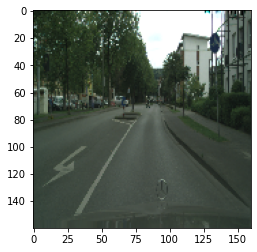

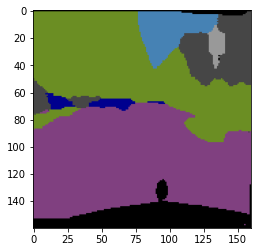

In [9]:
rand_idx = np.random.randint(0, len(test_input_img_paths))

test_img = np.array(load_img(test_input_img_paths[rand_idx], target_size=img_size))
plt.imshow(test_img)
plt.show()

pred = cityscapes_category_ids_to_category_colors(
    np.squeeze(np.argmax(model.predict(np.expand_dims(test_img, 0)), axis=-1))
)
plt.imshow(pred)
plt.show()
